In [1]:
import json
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from IPython.display import clear_output
import sys
import rich
import pickle
import os
from pathlib import Path

# source /home/phbelang/abp/BBStudies/Executables/py_BB/bin/activate
if 'BBStudies/Executables/py_BB/bin' not in os.environ.get('PATH').split(':')[0]:
    raise Exception('Wrong Python Distribution, use BBStudies/Executables/py_BB')


import xobjects as xo
import xtrack as xt
import xpart as xp
import xfields as xf

sys.path.append('/home/phbelang/abp/BBStudies/')
# Linux local
sys.path.append('/home/pbelanger/ABPlocal/BBStudies')
# Mac local
sys.path.append('/Users/pbelanger/ABPLocal/BBStudies/')
import BBStudies.Tracking.XsuitePlus as xPlus
import BBStudies.Tracking.InteractionPoint as inp
import BBStudies.Physics.Detuning as dtune
import BBStudies.Physics.Base as phys
import BBStudies.Plotting.BBPlots as bbplt
import BBStudies.Physics.Constants as cst


LINEFOLDER = './Lines/'
def import_from_lines(line_ID,to_track):
    line   = {}
    twiss  = {}
    survey = {}

    for seq in ['lhcb1','lhcb4']:
        _beam = seq[-2:]
        # Importing Line
        line[_beam] = xPlus.importLine(LINEFOLDER + f'line_{line_ID}_{seq}.json')
        
        # Importing twiss and tracker
        if _beam == 'b1':
            tracker_b1    = line[_beam].build_tracker()#xt.Tracker(line=line[_beam])
            twiss[_beam]  = tracker_b1.twiss().to_pandas(index="name")
            survey[_beam] = tracker_b1.survey().to_pandas(index="name")
        elif _beam == 'b4':
            tracker_b4    = line[_beam].build_tracker()#xt.Tracker(line=line[_beam])
            twiss[_beam]   = tracker_b4.twiss().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().to_pandas(index="name")

            _beam = 'b2'
            twiss[_beam]   = tracker_b4.twiss().reverse().to_pandas(index="name")
            survey[_beam]  = tracker_b4.survey().reverse().to_pandas(index="name")


    if to_track == 'b1':
        tracker = tracker_b1
        del tracker_b4
    else:
        tracker = tracker_b4
        del tracker_b1
    # Clearing xsuite ouput
    clear_output(wait=False)



    allVars = list(tracker.vars._owner.keys())
    allElements = list(tracker.element_refs._owner.keys())


    # Deactivating all wires
    #===================================================
    tracker.vars['enable_qff'] = 0
    for IP in ['ip1','ip5']:
        tracker.vars[f"bbcw_rw_{IP}.{_beam}"] = 1
        tracker.vars[f"bbcw_i_{IP}.{_beam}"]  = 0
    run3_wires = [name for name in allElements if ('bbcw' in name)&('wire' in name)]
    for wire in run3_wires:
        tracker.line.element_dict[wire].post_subtract_px  = 0
        tracker.line.element_dict[wire].post_subtract_py  = 0
        
    # Creating BB knobs
    #===================================================
    
    for _ip in ['ip1','ip5','ip2','ip8']:
        bb_lr = [name for name in allElements if ('bb_lr' in name)&(f'{_ip[-1]}{_beam}' in name)]
        bb_ho = [name for name in allElements if ('bb_ho' in name)&(f'{_ip[-1]}{_beam}' in name)]

        # New knob:
        tracker.vars[f'{_ip}_bblr_ON'] = 1
        tracker.vars[f'{_ip}_bbho_ON'] = 1

        # Linking to new knob 
        for _lr in bb_lr:
            # Infividual knobs
            tracker.vars[f'{_lr}_ON'] = 1
            tracker.element_refs[_lr].scale_strength = tracker.vars[f'{_lr}_ON']*tracker.vars[f'{_ip}_bblr_ON']*tracker.element_refs[_lr].scale_strength._value

        for _ho in bb_ho:
            tracker.element_refs[_ho].scale_strength = tracker.vars[f'{_ip}_bbho_ON']*tracker.element_refs[_ho].scale_strength._value

    # Creating sext and oct knobs
    #====================================================

    # AS DONE IN THE MASK
    #---------------------
    part = tracker.line.particle_ref
    brho = part.p0c[0]/(part.q0*cst.c)
    tracker.vars['I_oct'] = 0
    for ss in '12 23 34 45 56 67 78 81'.split():
        tracker.vars[f'kof.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
        tracker.vars[f'kod.a{ss}{_beam}'] = tracker.vars['kmax_mo']*tracker.vars['I_oct']/tracker.vars['imax_mo']/brho
    #---------------------

    
    ks = [name for name in allVars if ('ksf' in name)|('ksd' in name)]
    ko = [name for name in allVars if ('kof.a' in name)|('kod.a' in name)]

    tracker.vars['all_oct_ON']  = 1
    tracker.vars['all_sext_ON'] = 1
    for _ks in ks:
        if tracker.vars[_ks]._expr is None:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._value
        else:
            tracker.vars[_ks] = tracker.vars['all_sext_ON']*tracker.vars[_ks]._expr 
    for _ko in ko:
        if tracker.vars[_ko]._expr is None:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._value
        else:
            tracker.vars[_ko] = tracker.vars['all_oct_ON']*tracker.vars[_ko]._expr 

    return tracker,line,twiss,survey

import yaml
def import_IP_config(line_ID,twiss,survey):
    # Loading config
    #============================

    with open(LINEFOLDER+f'../Configs/config_{line_ID}.yaml','r') as fid:
        configuration = yaml.safe_load(fid)




    B1 = inp.Beam('b1',twiss['b1'],survey['b1'],
                Nb       = float(configuration['beam_npart']),
                E        = float(configuration['beam_energy_tot'])*1e9,
                emittx_n = configuration['beam_norm_emit_x']*1e-6,
                emitty_n = configuration['beam_norm_emit_y']*1e-6,
                dp_p0    = 0)
        
    B2 = inp.Beam('b2',twiss['b2'],survey['b2'],
                Nb       = float(configuration['beam_npart']),
                E        = float(configuration['beam_energy_tot'])*1e9,
                emittx_n = configuration['beam_norm_emit_x']*1e-6,
                emitty_n = configuration['beam_norm_emit_y']*1e-6,
                dp_p0    = 0)

    IP1 = inp.InteractionPoint('ip1',B1,B2)
    IP5 = inp.InteractionPoint('ip5',B1,B2)

    return IP1,IP5

def generate_particles(tracker,B1,B2,to_track,method='6d',contour = False):
    
    BEAM = {'b1':B1,'b4':B2}[to_track]
    # Generating Coord grid
    #=========================================================
    coordinates = phys.polar_grid(  r_sig     = np.array([1e-6] + list(np.linspace(1,6.5,3))),
                                    theta_sig = np.linspace(0.02*np.pi/2,0.98*np.pi/2,3),
                                    emitt     = [BEAM.emittx,BEAM.emitty])
    coordinates.insert(0,'delta',0)

    if contour:
        ctour_idx  = list(coordinates[coordinates['theta_sig'] == np.min(coordinates['theta_sig'])].index)
        ctour_idx += list(coordinates[coordinates['r_sig'] == np.max(coordinates['r_sig'])].index)[1:-1]
        ctour_idx += list(coordinates[coordinates['theta_sig'] == np.max(coordinates['theta_sig'])].index)[::-1]
        ctour_idx += list(coordinates[coordinates['r_sig'] == np.min(coordinates['r_sig'])].index)[1:-1][::-1]

        coordinates = coordinates.loc[ctour_idx]

    group_length = len(coordinates)

    # Generation
    p0        = xp.Particles(mass0=tracker.line.particle_ref.mass0, q0 = tracker.line.particle_ref.q0 , p0c=tracker.line.particle_ref.p0c)
    particles = xp.build_particles( method       = method,
                                    particle_ref = p0,
                                    tracker      = tracker,
                                    x_norm       = coordinates['x_sig'].values, 
                                    px_norm      = None, 
                                    y_norm       = coordinates['y_sig'].values, 
                                    py_norm      = None,
                                    zeta         = None,
                                    delta        = coordinates['delta'].values,
                scale_with_transverse_norm_emitt = [BEAM.emittx_n,BEAM.emitty_n])
    
    return particles,coordinates


def match_tracker(tracker,to_track):
    if to_track == 'b4':
        to_track = 'b2'
    # Matching
    #===================================
    for _ip in ['ip1','ip5','ip2','ip8']:
        tracker.vars[f'{_ip}_bblr_ON'] = 0
        tracker.vars[f'{_ip}_bbho_ON'] = 0

    tracker.vars['all_oct_ON']   = 1
    tracker.vars['all_sext_ON']  = 1

    tw_final = tracker.twiss()
    Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
    print('\nInitial twiss parameters')
    print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
        f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
    print(40*'-')

    try:
        tracker.match(vary=[f'dqx.{to_track}',f'dqy.{to_track}'],
            targets = [
                ('qx', 62.31),
                ('qy', 60.32)])
                
        tracker.match(vary=[f'dqpx.{to_track}_sq',f'dqpy.{to_track}_sq'],
            targets = [
                ('dqx', 15.0),
                ('dqy', 15.0)])
    except RuntimeError:
        print('Matching didnt find an improvement')





    tw_final = tracker.twiss()
    Qx_0,Qy_0 = np.round(np.mod(tw_final['qx'],1),4),np.round(np.mod(tw_final['qy'],1),4)
    print('\nFinal twiss parameters')
    print(f"Qx = {tw_final['qx']:.5f} Qy = {tw_final['qy']:.5f} "
        f"Q'x = {tw_final['dqx']:.5f} Q'y = {tw_final['dqy']:.5f}")
    #===================================



# line_ID    = 'ID05_t0'
# to_track   = 'b4'


# # Importing and Filtering twiss
# #====================================
# tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
# twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
# twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..','bbcw'])
# #====================================

# # Importing IP Objects
# #====================================
# IP1,IP5 = import_IP_config(line_ID,twiss,survey)
# #====================================



---
# Coordinates
---

(-0.3248395991375657, 6.82163227292558, -0.3248395991375657, 6.82163227292558)

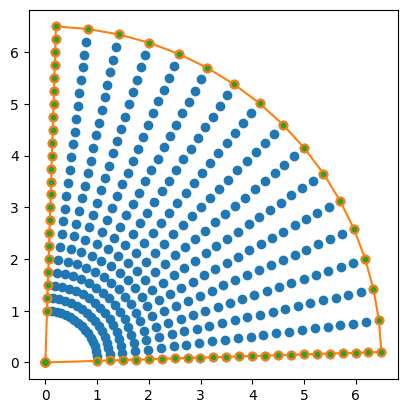

In [6]:
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=False)


plt.figure()
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=False)
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'o')
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=True)
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'-o')
plt.plot(coordinates['x_sig'],coordinates['y_sig'],'.')


plt.axis('square')
# plt.xlim([0,1.5])
# plt.ylim([0,1.5])

---
# TRACKING
---

In [2]:

to_track = 'b4'
CONTOUR  = False
OUTFOLDER = './DAtracking'
NTURNS = int(1e5)
for line_ID in ['base']:

# for line_ID in ['base']:
    # Importing and Filtering twiss
    #====================================
    tracker,line,twiss,survey = import_from_lines(line_ID,to_track)
    twiss['b1'] = xPlus.filter_twiss(twiss['b1'],entries=['drift','..'])
    twiss['b2'] = xPlus.filter_twiss(twiss['b2'],entries=['drift','..'])
    #====================================
    
    # Importing IP Objects
    #====================================
    IP1,IP5 = import_IP_config(line_ID,twiss,survey)
    #====================================
    
 
    # Matching
    #====================================
    match_tracker(tracker,to_track)
    #====================================

    # REFERENCE
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 0
    tracker.vars[f'ip5_bbho_ON'] = 0

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_ref = xPlus.Tracking(tracker, particles, n_turns = NTURNS,method='4D',progress=True)
    tracked_ref.to_pickle(f'{OUTFOLDER}/tracked_ref_sf1_{line_ID}.pkl')
    coordinates[['r_sig','theta_sig','x_sig','y_sig']].to_pickle(f'{OUTFOLDER}/coordinates_{line_ID}.pkl')

    # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 1
    tracker.vars[f'ip5_bbho_ON'] = 1

    tracker.vars[f'ip1_bblr_ON'] = 0
    tracker.vars[f'ip5_bblr_ON'] = 0

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_HO = xPlus.Tracking(tracker, particles, n_turns = NTURNS,method='4D',progress=True)
    tracked_HO.to_pickle(f'{OUTFOLDER}/tracked_HO_sf1_{line_ID}.pkl')


    # Choosing knobs
    #==========================
    tracker.vars[f'ip1_bbho_ON'] = 1
    tracker.vars[f'ip5_bbho_ON'] = 1

    tracker.vars[f'ip1_bblr_ON'] = 1
    tracker.vars[f'ip5_bblr_ON'] = 1

    tracker.vars['all_oct_ON']   = 0
    tracker.vars['all_sext_ON']  = 1
    #==========================

    particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)
    particles.zeta  *= 0
    particles.delta *= 0
    tracked_HOLR = xPlus.Tracking(tracker, particles, n_turns = NTURNS,method='4D',progress=True)
    tracked_HOLR.to_pickle(f'{OUTFOLDER}/tracked_HOLR_sf1_{line_ID}.pkl')





Initial twiss parameters
Qx = 62.31001 Qy = 60.32001 Q'x = 14.98487 Q'y = 15.00365
----------------------------------------

Final twiss parameters
Qx = 62.31000 Qy = 60.32000 Q'x = 15.00000 Q'y = 15.00000


Output()

generating ./69491f4bae904fdd932c64fc6528bbc6.c
the current directory is '/Users/pbelanger/cernbox/Programming/QFPCatalogue'
running build_ext
building '69491f4bae904fdd932c64fc6528bbc6' extension
clang -Wno-unused-result -Wsign-compare -Wunreachable-code -DNDEBUG -fwrapv -O2 -Wall -fPIC -O2 -isystem /Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/include -arch arm64 -I/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/include -fPIC -O2 -isystem /Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/include -arch arm64 -I/Users/pbelanger/ABPLocal/BBStudies/Executables/py_BB/include -I/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/include/python3.9 -c 69491f4bae904fdd932c64fc6528bbc6.c -o ./69491f4bae904fdd932c64fc6528bbc6.o -std=c99 -O3 -Wno-unused-function


clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -L/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -L/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -Wl,-rpath,/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -L/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -arch arm64 ./69491f4bae904fdd932c64fc6528bbc6.o -o ./69491f4bae904fdd932c64fc6528bbc6.cpython-39-darwin.so -std=c99 -O3


458828f468414ac59b931c66caf9ca2b.c:4474:11: warning: '_GNU_SOURCE' macro redefined [-Wmacro-redefined]
#  define _GNU_SOURCE // enable GNU libc NAN extension if possible
          ^
/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/include/python3.9/pyconfig.h:1597:9: note: previous definition is here
#define _GNU_SOURCE 1
        ^
458828f468414ac59b931c66caf9ca2b.c:13816:12: warning: variable 'gamma' set but not used [-Wunused-but-set-variable]
    double gamma = energy / m0; // [1] 
           ^


clang -bundle -undefined dynamic_lookup -Wl,-rpath,/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -L/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -L/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -Wl,-rpath,/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -L/Users/pbelanger/ABPLocal/BBStudies/Executables/miniconda/lib -arch arm64 ./458828f468414ac59b931c66caf9ca2b.o -o ./458828f468414ac59b931c66caf9ca2b.cpython-39-darwin.so -std=c99 -O3


2 warnings generated.


Output()

Output()

---
# DEBUG
---

In [10]:
particles,coordinates = generate_particles(tracker,IP1.b1,IP1.b2,to_track,method='4d',contour=CONTOUR)

In [3]:
tracked = {}
tracked['ref'] = tracked_ref
tracked['HO']  = tracked_HO
tracked['sf'] = 10
tracked['coord'] = coordinates
skipfirst = 15
_coord = tracked['coord']
ctour_idx  = list(_coord[_coord['theta_sig'] == np.min(_coord['theta_sig'])].index)
ctour_idx += list(_coord[_coord['r_sig'] == np.max(_coord['r_sig'])].index)[1:-1]
ctour_idx += list(_coord[_coord['theta_sig'] == np.max(_coord['theta_sig'])].index)[::-1]
ctour_idx += list(_coord[_coord['r_sig'] == np.min(_coord['r_sig'])].index)[1:-1][::-1]
tracked['ctour_idx'] = ctour_idx[:-skipfirst]

ValueError: not enough values to unpack (expected 2, got 0)

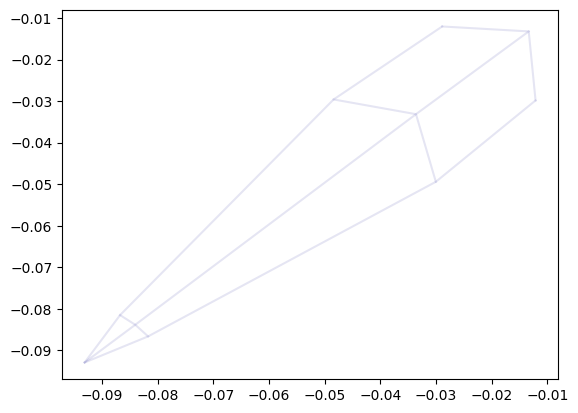

In [4]:
dQx,dQy = np.zeros(len(tracked['coord'])),np.zeros(len(tracked['coord']))
for i in ['HO']:
    #---------------
    _dQx = tracked[i].tunes_n['Qx'] - tracked['ref'].tunes_n['Qx']
    _dQy = tracked[i].tunes_n['Qy'] - tracked['ref'].tunes_n['Qy']

    # Scale for scale_strength factor
    dQx += _dQx*tracked['sf']
    dQy += _dQy*tracked['sf']
    #---------------



plt.figure()
color = 'darkblue'
#------------
x = dQx
y = dQy
#------------
#template_FP_plot(window = 0.02,show_WP=False,show_Res=False)
bbplt.polarmesh(x,y,alpha=0.1,r=tracked['coord']['r_sig'],theta=tracked['coord']['theta_sig'],color=color)
#plt.scatter(x,y,c=color,s = 30*sciStat.norm.pdf(tracked['coord']['r_sig'])/sciStat.norm.pdf(0))
x = x.loc[tracked['ctour_idx']]
y = y.loc[tracked['ctour_idx']]
plt.plot(x,y,'-',alpha=0.5,color=color)
start,stop = (len(x))//4,(len(y))//4+3
bbplt.drawArrow(x.values[start:stop],y.values[start:stop],scale=2.5,color=color,alpha=0.8,label = None,zorder=100)
start,stop = 3*(len(x))//4,3*(len(y))//4+3
bbplt.drawArrow(x.values[start:stop][::-1],y.values[start:stop][::-1],scale=2.5,facecolor='white',color=color,alpha=0.8,label = None,zorder=100)

plt.axis('square');
plt.locator_params(nbins=6)
plt.xlabel(r'$\Delta Q_x/\xi$')
plt.ylabel(r'$\Delta Q_y/\xi$')

#===========================

In [5]:
import gc

In [6]:
gc.collect()

2505